In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import seaborn as sns
from LabUtils.Utils import mkdirifnotexists
from mne.stats import fdr_correction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import modality_name_mapping, \
    work_dir, pred_dir, pred_residuals_fig_dir, load_ranked_residuals, male_color, female_color

In [13]:
fig_dir = mkdirifnotexists(os.path.join(work_dir, 'figures', 'figure1'))

In [14]:
cat_to_exclude = ['diet_questions', 'medical_conditions', 'medications']

# version with error bars
def barplot(ax, no_xticklabels=False):
#     fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    r = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).filter(regex='equal').drop(cat_to_exclude, axis=0)
    r = r.loc[~r.index.str.contains('full')]
    r1 = r.reset_index().melt(id_vars=['index'] + r.filter(regex='0.0|0.9').columns.tolist(),
                              value_vars=['female_equal 0.5'])
    r1['min_error'] = r1['value'] - r1['female_equal 0.025']
    r1['max_error'] = r1['female_equal 0.975'] - r1['value']
    r2 = r.reset_index().melt(id_vars=['index'] + r.filter(regex='0.0|0.9').columns.tolist(),
                              value_vars=['male_equal 0.5'])
    r2['min_error'] = r2['value'] - r2['male_equal 0.025']
    r2['max_error'] = r2['male_equal 0.975'] - r2['value']
    r = pd.concat((r1, r2), axis=0)
    r['max_r2'] = r[['female_equal 0.975', 'male_equal 0.975']].max(1)
    r = r.sort_values(['max_r2', 'index', 'variable'], ascending=False)
    r.replace({'index': modality_name_mapping}, inplace=True)
    r.replace({'variable': {'male_equal 0.5': 'Males', 'female_equal 0.5': 'Females'}}, inplace=True)

    ax = sns.barplot(data=r, x='index', y='value', hue='variable', ax=ax, palette=[male_color, female_color])
#     ax.set_xlabel('Data modality', fontsize=15)
    ax.set_xlabel('', fontsize=15)
    ax.set_ylabel(r'$R^2$ of chronological age', fontsize=15)
    ax.tick_params(labelsize=15)
    if no_xticklabels:
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, r.index.unique().shape[0]-0.5)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    legend = ax.legend(loc='best', title='Sex', fontsize=15)
    plt.setp(legend.get_title(), fontsize=15)

    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    ax.errorbar(x=x_coords, y=y_coords,
                yerr=r[["min_error", "max_error"]].iloc[pd.Series(x_coords).rank() - 1].T.values, fmt="none", c="k")
    return r
#     plt.tight_layout()
# plt.savefig(os.path.join(work_dir, 'results_by_gender_w_errbars.png'), dpi=200)

In [24]:
from scipy.stats import pearsonr

min_size = 1471
rank_or_z = 'centered' # 'zscore'

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    min_val = 5000
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
#             print(tmp.shape[0])
            if tmp.shape[0] < min_val:
                min_val = tmp.shape[0]
            np.random.seed(0)
            tmp = tmp.iloc[np.random.choice(range(tmp.shape[0]), size=min_size, replace=False)]
#             print(tmp.shape)
            pvalues[r][c] = pearsonr(tmp[r], tmp[c])[1]
#     print(min_val)
    return pvalues


def get_clustered_mats(res_r2_th=0, rank_or_z=rank_or_z, order=None):
    res = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude, axis=0)
    res = res.loc[~res.index.str.contains('full')]
    fig_dir = mkdirifnotexists(os.path.join(pred_residuals_fig_dir, 'correlation_matrix'))

#     res[res['full model all'] > res_r2_th]

    male_residuals_df = load_ranked_residuals(res, '_male_equal', permuted=False, rank_or_z=rank_or_z).rename(columns=modality_name_mapping)
    female_residuals_df = load_ranked_residuals(res, '_female_equal', permuted=False, rank_or_z=rank_or_z).rename(columns=modality_name_mapping)
    if order is not None:
        male_residuals_df = male_residuals_df.reindex(order, axis=1)
        female_residuals_df = female_residuals_df.reindex(order, axis=1)
    
    male_corr_mat = male_residuals_df.corr()
    female_corr_mat = female_residuals_df.corr()
    
    
    male_corr_p = calculate_pvalues(male_residuals_df.rename(columns=modality_name_mapping))
    female_corr_p = calculate_pvalues(female_residuals_df.rename(columns=modality_name_mapping))
    
    mask = np.triu(np.ones_like(male_corr_mat, dtype=bool), k=0)
    if order is None:
        cg1 = sns.clustermap(male_corr_mat, xticklabels=False, yticklabels=False, metric='correlation')
        plt.clf()
        male_corr_mat = male_corr_mat.iloc[cg1.dendrogram_row.reordered_ind, cg1.dendrogram_col.reordered_ind].iloc[1:, :-1]
        female_corr_mat = female_corr_mat.iloc[cg1.dendrogram_row.reordered_ind, cg1.dendrogram_col.reordered_ind].iloc[1:, :-1]
        male_corr_p = male_corr_p.iloc[cg1.dendrogram_row.reordered_ind, cg1.dendrogram_col.reordered_ind].iloc[1:, :-1]
        female_corr_p = female_corr_p.iloc[cg1.dendrogram_row.reordered_ind, cg1.dendrogram_col.reordered_ind].iloc[1:, :-1]
        mask = np.triu(np.ones_like(male_corr_mat, dtype=bool), k=1)
    male_corr_p[mask] = np.nan
    female_corr_p[mask] = np.nan
    male_corr_p_mask = ~(fdr_correction(male_corr_p, alpha=0.01)[1] < 0.01) | mask
    female_corr_p_mask = ~(fdr_correction(female_corr_p, alpha=0.01)[1] < 0.01) | mask
    return male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask

def plot_residuals_correlation_matrix(male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask, axes):
    
#     fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    ax = axes[0]
    sns.heatmap(male_corr_mat, ax=ax, annot=True, mask=male_corr_p_mask, center=0, fmt="0.2f", 
                annot_kws={'size': 7}, cbar=False,
                cmap='RdBu_r', vmin=-0.2, vmax=0.5, linewidths=0.5, linecolor='white', clip_on=False)
    ax.set_title('Males', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
    ax = axes[1]
    sns.heatmap(female_corr_mat, ax=ax, annot=True, mask=female_corr_p_mask, center=0, fmt="0.2f", 
                annot_kws={'size': 7}, cbar=False,
                cmap='RdBu_r', yticklabels=False, vmin=-0.2, vmax=0.5, linewidths=0.5, linecolor='white', clip_on=False)
    ax.set_title('Females', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax = axes[2]
    sns.heatmap(female_corr_mat - male_corr_mat, ax=ax, annot=True, mask=male_corr_p_mask & female_corr_p_mask, 
                center=0, fmt="0.2f",
                annot_kws={'size': 7}, cbar=False, cmap='RdBu_r', yticklabels=False, vmin=-0.2, vmax=0.5,
                linewidths=0.5, linecolor='white', clip_on=False)
    ax.set_title('Females minus Males', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    clb = plt.colorbar(ax.get_children()[0], orientation="vertical",
                       ticks=[-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], aspect=20, cax=axes[3])
    clb.ax.set_ylabel('Pearson correlation', fontsize=15)
#     plt.tight_layout()

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.


<Figure size 720x720 with 0 Axes>

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


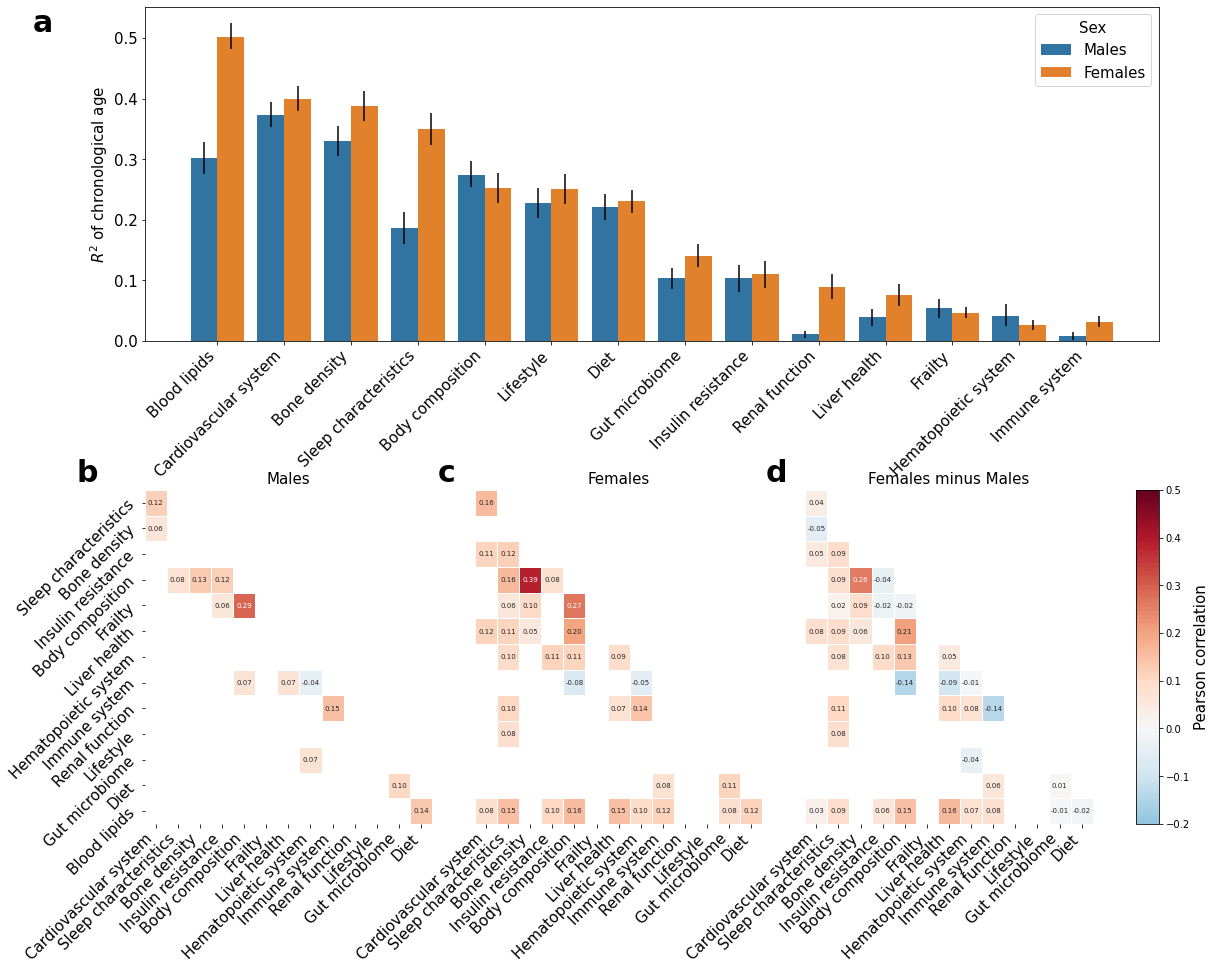

In [169]:
male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask = get_clustered_mats()

ax_dict = plt.figure(constrained_layout=True, figsize=(15, 12)).subplot_mosaic(
    """
    AAAAAAAAAAAAAAAA
    BBBBBCCCCCDDDDDE
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)

barplot(ax_dict["A"])
plot_residuals_correlation_matrix(male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask, 
                                  (ax_dict["B"], ax_dict["C"], ax_dict["D"], ax_dict["E"]))
ax_dict["A"].text(-0.1, 0.95, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.2, 1.05, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')
ax_dict["C"].text(-0.1, 1.05, 'c', ha='center', va='center', transform=ax_dict["C"].transAxes, fontsize=30, weight='bold')
ax_dict["D"].text(-0.1, 1.05, 'd', ha='center', va='center', transform=ax_dict["D"].transAxes, fontsize=30, weight='bold')
# plt.tight_layout()

plt.savefig(os.path.join(fig_dir, 'figure1.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure1.pdf'), dpi=300, bbox_inches='tight')

# v2

In [25]:
def interchange_dfs(df1, df2, separate_by_empty=False):
    merged_cols = df1.columns.tolist() + [c for c in df2.columns if c not in df1.columns]
    merged_idx = df1.index.tolist() + [c for c in df2.index if c not in df1.index]
    d1_t = df1.reindex(merged_idx, axis=0).reindex(merged_cols, axis=1)
    d2_t = df2.reindex(merged_idx, axis=0).reindex(merged_cols, axis=1)
    if separate_by_empty:
        d3 = pd.concat([pd.concat((d1_t[[c]], d2_t[[c]], pd.DataFrame(columns=[''])), axis=1) for c in merged_cols], axis=1)
    else:
        d3 = pd.concat([pd.concat((d1_t[[c]], d2_t[[c]]), axis=1) for c in merged_cols], axis=1)
    return d3
    

def plot_interchange_heatmap(df_merged, df_merged_mask, ax, label1='F', label2='M'):
    sns.heatmap(df_merged.astype(float), 
            linecolor='white', cbar=False, ax=ax, linewidths=0.5, 
                center=0, cmap='PRGn', mask=df_merged_mask, annot=False, fmt="0.2f", 
                annot_kws={'size': 7}) # linewidths=0.5
    M = df_merged.shape[1]
    for i in range(0, M + 1, 2):
        ax.axvline(i, color='white', lw=10, clip_on=False)
        if i > 0:
            ax.axvline(i-0.25, color='lightgrey', lw=1, clip_on=False)
        if i < M:
            ax.axvline(i+0.2, color='lightgrey', lw=1, clip_on=False)
            ax.text(i+1-0.4, -0.1, label1, ha='center', fontsize=15)
            ax.text(i+1+0.4, -0.1, label2, ha='center', fontsize=15)
    ax.set_xticks(range(1, M+1, 2))
    ax.set_xticklabels([df_merged.columns[i] for i in range(0, df_merged.shape[1], 2)])
    ax.tick_params(labelsize=15, left=True, bottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    clb = plt.colorbar(ax.get_children()[0], orientation="vertical", aspect=20, pad=0.01)
    clb.ax.set_ylabel('Pearson correlation', fontsize=15)
    clb.ax.tick_params(labelsize=15)
    ax.tick_params(labelsize=15, left=False, bottom=True)
    
    

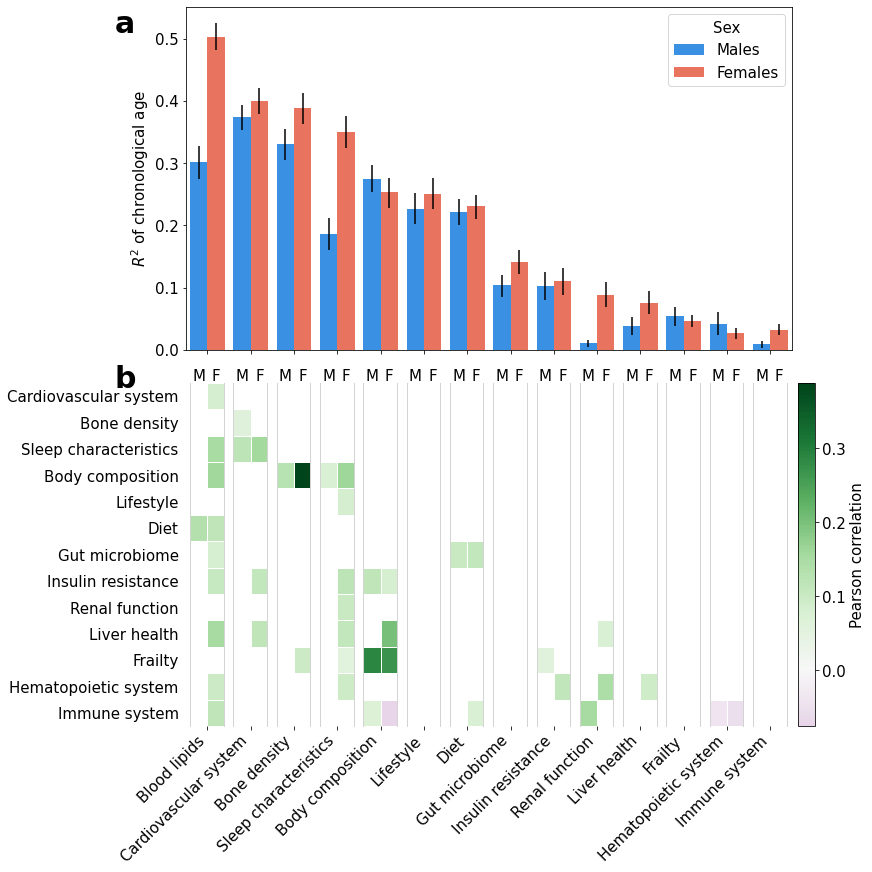

In [92]:


ax_dict = plt.figure(constrained_layout=True, figsize=(12, 12)).subplot_mosaic(
    """
    A
    B
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)

r = barplot(ax_dict["A"], True)

male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask = get_clustered_mats(order=r['index'].unique())

df_merged = interchange_dfs(male_corr_mat, female_corr_mat, False)
df_merged_mask = interchange_dfs(pd.DataFrame(male_corr_p_mask, index=male_corr_mat.index, columns=male_corr_mat.columns), 
                                 pd.DataFrame(female_corr_p_mask, index=female_corr_mat.index, columns=female_corr_mat.columns), False)

plot_interchange_heatmap(df_merged=df_merged.iloc[1:], df_merged_mask=df_merged_mask.iloc[1:], 
                         ax=ax_dict["B"], label1='M', label2='F')



ax_dict["A"].text(-0.1, 0.95, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.1, 1.01, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(fig_dir, 'figure1_v2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure1_v2.pdf'), dpi=300, bbox_inches='tight')

Text(-0.1, 1.01, 'b')

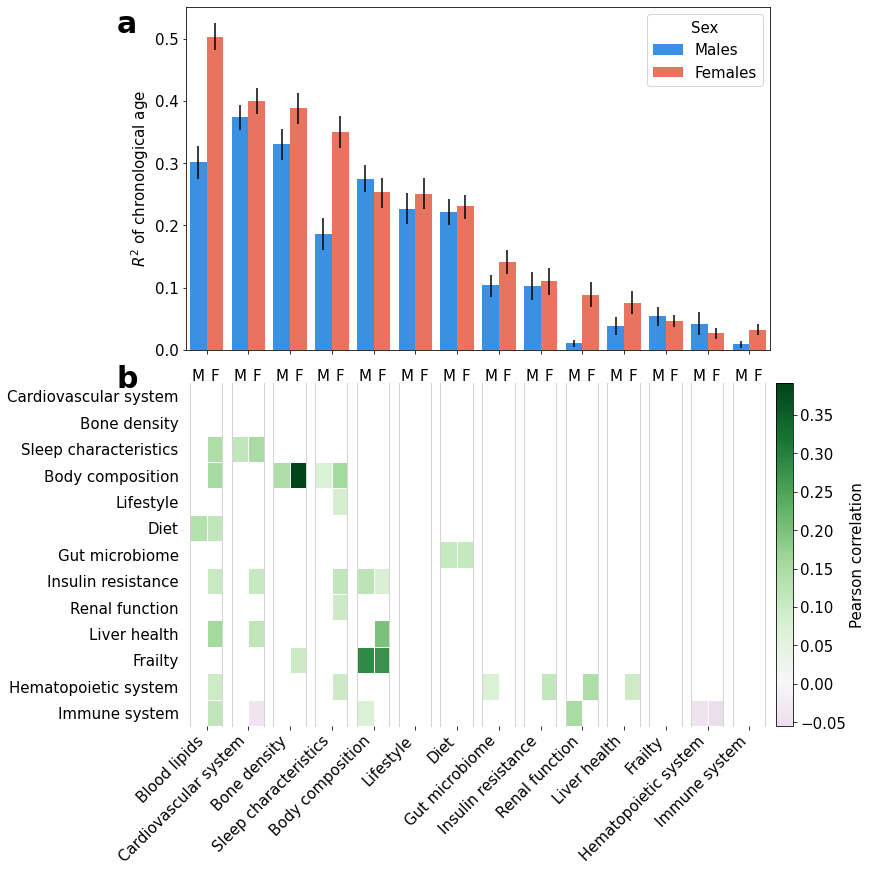

In [10]:


ax_dict = plt.figure(constrained_layout=True, figsize=(12, 12)).subplot_mosaic(
    """
    A
    B
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)

r = barplot(ax_dict["A"], True)

male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask = get_clustered_mats(order=r['index'].unique())

df_merged = interchange_dfs(male_corr_mat, female_corr_mat, False)
df_merged_mask = interchange_dfs(pd.DataFrame(male_corr_p_mask, index=male_corr_mat.index, columns=male_corr_mat.columns), 
                                 pd.DataFrame(female_corr_p_mask, index=female_corr_mat.index, columns=female_corr_mat.columns), False)

plot_interchange_heatmap(df_merged=df_merged.iloc[1:], df_merged_mask=df_merged_mask.iloc[1:], 
                         ax=ax_dict["B"], label1='M', label2='F')



ax_dict["A"].text(-0.1, 0.95, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.1, 1.01, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')

# plt.savefig(os.path.join(fig_dir, 'figure1_v2.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, 'figure1_v2.pdf'), dpi=300, bbox_inches='tight')

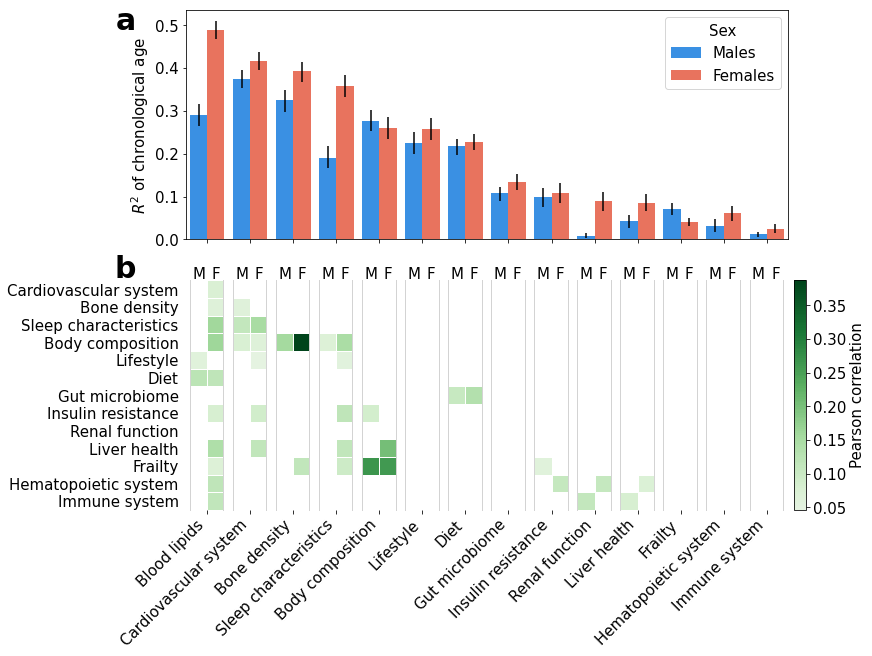

In [61]:


ax_dict = plt.figure(constrained_layout=True, figsize=(12, 9)).subplot_mosaic(
    """
    A
    B
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)

r = barplot(ax_dict["A"], True)

male_corr_mat, female_corr_mat, male_corr_p_mask, female_corr_p_mask, mask = get_clustered_mats(order=r['index'].unique())

df_merged = interchange_dfs(male_corr_mat, female_corr_mat, False)
df_merged_mask = interchange_dfs(pd.DataFrame(male_corr_p_mask, index=male_corr_mat.index, columns=male_corr_mat.columns), 
                                 pd.DataFrame(female_corr_p_mask, index=female_corr_mat.index, columns=female_corr_mat.columns), False)

plot_interchange_heatmap(df_merged=df_merged.iloc[1:], df_merged_mask=df_merged_mask.iloc[1:], 
                         ax=ax_dict["B"], label1='M', label2='F')



ax_dict["A"].text(-0.1, 0.95, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.1, 1.05, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(fig_dir, 'figure1_v2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure1_v2.pdf'), dpi=300, bbox_inches='tight')

In [56]:
(~female_corr_p_mask).sum()
(~male_corr_p_mask).sum()

13

In [51]:
male_corr_mat

,Blood lipids,Cardiovascular system,Bone density,Sleep characteristics,Body composition,Lifestyle,Diet,Gut microbiome,Insulin resistance,Renal function,Liver health,Frailty,Hematopoietic system,Immune system
Blood lipids,1.000000,0.085729,0.017503,0.053383,0.006382,0.058799,0.122188,0.107296,0.082361,0.053843,-0.039931,0.003390,0.050101,0.036229
Cardiovascular system,0.085729,1.000000,0.062566,0.111839,0.076916,-0.000469,0.007644,-0.006991,0.070850,-0.004292,0.037391,-0.017467,-0.010076,-0.007771
Bone density,0.017503,0.062566,1.000000,0.028543,0.156254,-0.012008,-0.003868,-0.022858,0.026505,0.051357,0.012223,-0.002620,0.008272,0.038130
Sleep characteristics,0.053383,0.111839,0.028543,1.000000,0.069466,-0.005726,-0.012880,0.014564,0.044123,0.024689,0.033605,0.029593,0.029597,0.071273
Body composition,0.006382,0.076916,0.156254,0.069466,1.000000,-0.041600,-0.012293,0.016717,0.086502,-0.007314,0.010598,0.267114,-0.031436,0.049347
Lifestyle,0.058799,-0.000469,-0.012008,-0.005726,-0.041600,1.000000,0.025198,0.033921,-0.004777,0.040961,-0.007309,-0.024068,0.009504,0.003107
Diet,0.122188,0.007644,-0.003868,-0.012880,-0.012293,0.025198,1.000000,0.105544,-0.019138,0.027873,0.026286,0.011956,0.035816,0.012973
Gut microbiome,0.107296,-0.006991,-0.022858,0.014564,0.016717,0.033921,0.105544,1.000000,-0.008942,0.034720,-0.000649,0.006759,0.034697,0.028640
Insulin resistance,0.082361,0.070850,0.026505,0.044123,0.086502,-0.004777,-0.019138,-0.008942,1.000000,0.042301,-0.010926,0.059131,0.016286,0.048519
Renal function,0.053843,-0.004292,0.051357,0.024689,-0.007314,0.040961,0.027873,0.034720,0.042301,1.000000,-0.001535,-0.028832,0.059774,0.110370


(array([  14.,  121.,  585., 1672., 2896., 2706., 1466.,  449.,   81.,
          10.]),
 array([-3.7571685 , -2.9921732 , -2.22717791, -1.46218261, -0.69718731,
         0.06780798,  0.83280328,  1.59779858,  2.36279387,  3.12778917,
         3.89278447]),
 <BarContainer object of 10 artists>)

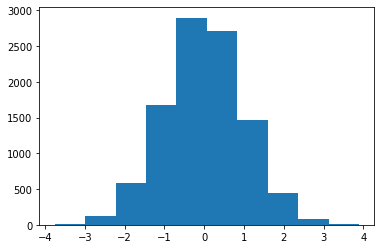

In [45]:
plt.hist(np.random.normal(0, 1, 10000))

(array([  15.,  125.,  596., 1591., 2699., 2585., 1637.,  591.,  136.,
          25.]),
 array([-3.59288817e+01, -2.87466138e+01, -2.15643459e+01, -1.43820781e+01,
        -7.19981019e+00, -1.75423087e-02,  7.16472557e+00,  1.43469934e+01,
         2.15292613e+01,  2.87115292e+01,  3.58937971e+01]),
 <BarContainer object of 10 artists>)

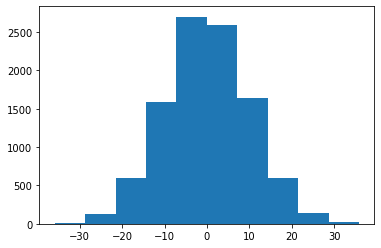

In [49]:
plt.hist(np.array([np.sum(np.random.normal(0, 1, 100)) for i in range(10000)]))

(array([  20.,  131.,  679., 1900., 3071., 2579., 1258.,  301.,   57.,
           4.]),
 array([-37.5022196 , -29.60392972, -21.70563985, -13.80734997,
         -5.9090601 ,   1.98922977,   9.88751965,  17.78580952,
         25.6840994 ,  33.58238927,  41.48067915]),
 <BarContainer object of 10 artists>)

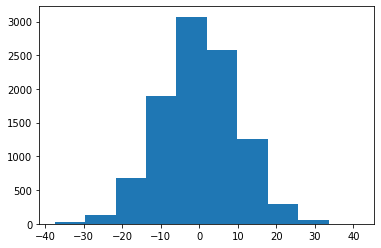

In [50]:
plt.hist(np.random.normal(0, np.sqrt(100), 1000))